# Path Planning

Planning is a crucial part of the autonomous driving pipeline. The subfield of planning corresponds to higher-level reasoning, where as last week's topic - control - focuses more on the specifics of how to move accurately. Planners come in many forms, but here, we're concerned with _motion planning_, or the task of moving from point A to B while avoiding collision with known obstacles. For simplicity, we will focusing on planning in a two-dimensional workspace, although many of the algorithms we see here can easily be extended to higher-dimensional spaces. 

In this exercise, you will complete the implementation of a popular robotic motion planning algorithm: Rapidly-Exploring Random Trees, or RRT for short. The successful completion of this algorithm will allow your simulated Duckiebot to go from your current position to a goal position in a road with obstacles. 

First, run this code to initialize the environment:

In [12]:
#%matplotlib 
#from matplotlib import use
#use('TkAgg')
import logging
logger = logging.getLogger("gym-duckietown")
logger.disabled = True

import os, sys
import math
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.helpers import launch_env, wrap_env, view_results_ipython, change_exercise, force_done, topViewSimulator, load_env_obstacles, proportional_next_point_controller, get_dist_to_goal
from simulation.gym_duckietown.wrappers import DiscreteWrapper, UndistortWrapper, SteeringToWheelVelWrapper
from simulation.gym_duckietown.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

In [13]:
local_env = topViewSimulator()
local_env = launch_env(simclass = topViewSimulator, map_name ="loop_obstacles")
local_env = wrap_env(local_env)
local_env = SteeringToWheelVelWrapper(local_env)
_ = local_env.reset()

print("Environment initialized.")

Environment initialized.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


You can view of the environment your Duckiebot will go through. Apart from the loop, you should see some cones, a couple of lost Duckies and another Duckiebot on the road!

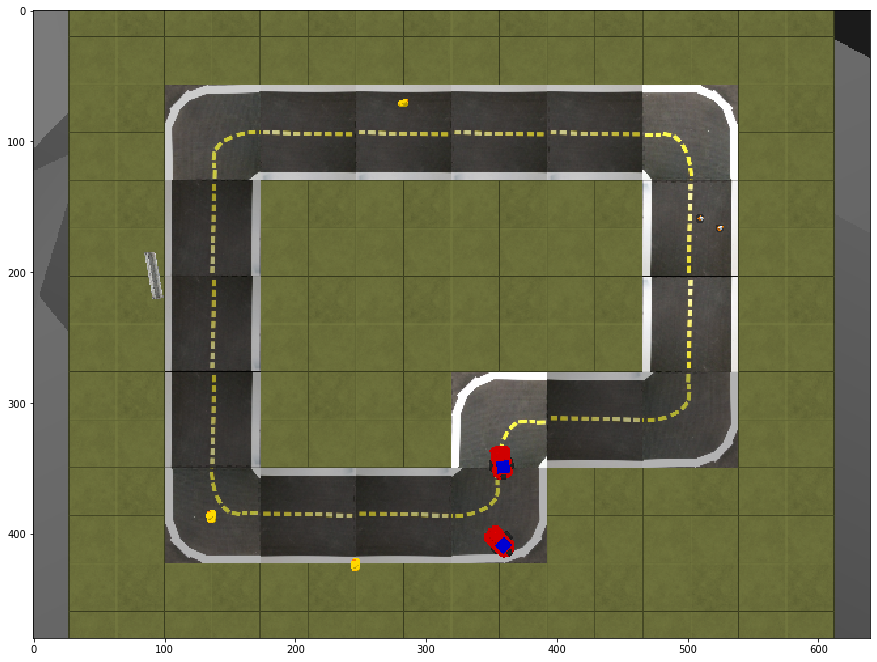

In [14]:
plt.figure(0, figsize = [15,21])
obs, _, d, _ = local_env.step([0, 0])
plt.imshow(obs, cmap='gray')
plt.show()

As we are working on path planning, we will make use of certain ground truth values that we can get from the simulator: the list of obstacles and the goal position.

For simplicity, the obstacles in this exercise are stationary and are modelled as circular. Their information, stored inside of `list_obstacles`, is a list containing each obstacle's parameters: `[x, y, diameter]`. 

Undrivable tiles are also represented by circular obstacles, helping us ensure that the Duckiebot can only drive on the road.

In [15]:
# Goal position
goal = [1,1]

# List of obstacles
list_obstacles = load_env_obstacles(local_env)
print('\n'.join('[{:f}, {:f}, {:f}]'.format(*obstacle) for obstacle in list_obstacles))

[2.047500, 0.702000, 0.172371]
[3.978000, 1.462500, 0.164603]
[3.861000, 1.404000, 0.164603]
[0.877500, 3.217500, 0.196495]
[2.632500, 3.363750, 0.317827]
[0.526500, 1.755000, 0.361167]
[1.755000, 3.510000, 0.196495]
[0.292500, 0.292500, 0.960500]
[0.292500, 0.877500, 0.960500]
[0.292500, 1.462500, 0.960500]
[0.292500, 2.047500, 0.960500]
[0.292500, 2.632500, 0.960500]
[0.292500, 3.217500, 0.960500]
[0.292500, 3.802500, 0.960500]
[0.877500, 0.292500, 0.960500]
[0.877500, 3.802500, 0.960500]
[1.462500, 0.292500, 0.960500]
[1.462500, 1.462500, 0.960500]
[1.462500, 2.047500, 0.960500]
[1.462500, 2.632500, 0.960500]
[1.462500, 3.802500, 0.960500]
[2.047500, 0.292500, 0.960500]
[2.047500, 1.462500, 0.960500]
[2.047500, 2.047500, 0.960500]
[2.047500, 2.632500, 0.960500]
[2.047500, 3.802500, 0.960500]
[2.632500, 0.292500, 0.960500]
[2.632500, 1.462500, 0.960500]
[2.632500, 2.047500, 0.960500]
[2.632500, 3.802500, 0.960500]
[3.217500, 0.292500, 0.960500]
[3.217500, 1.462500, 0.960500]
[3.21750

## Part 1. RRT

The following function allows you to build a path from your current position to the goal position while avoiding obstacles. The path is a list of x-y positions going backwards from the end goal to the start position. The planner uses the RRT (Rapidly Exploring Random Trees) algorithm that you have seen in class.

In this function, the `RRT_planner` class is called from your file `notebooks/code/exercise_03_path_planning/RRT.py`.

In [16]:
from notebooks.code.exercise_04_path_planning.RRT import RRT_planner
from IPython.display import clear_output

def make_plan(env, clear = False):
    ### Problem parameters
    # Start position
    start = env.cur_pos[0], env.cur_pos[2]
    # Area of exploration [x_min, x_max, y_min, y_max]
    rand_area = [0, 4.5, 0, 4.5]
    # No animation because we will call it many times in a row
    show_anim = False
    plt.figure(1)
    
    ### RRT Parameters
    # Distance of each step
    max_branch_length = 0.3
    # Resolution of the path (at which obstacles are checked)
    path_res = 0.1
    # Goal sampling rate : probability to artificially sample the goal
    goal_sample_rate=5
    # Max number of iterations
    max_iter = 10000
    
    ### Initializing and running the planner
    rrt_planner = RRT_planner(start, goal, list_obstacles, rand_area, max_branch_length, path_res, goal_sample_rate, max_iter)
    path = rrt_planner.plan(show_anim=show_anim)

    ### Finalization
    if path is None:
        print("Cannot find path.")
    else:
        print("Found path!")
        if True:
            if clear: clear_output()
            rrt_planner.draw_graph(final_path = path)
    return path

The control function, `proportional_next_point_controller`, will make the Duckiebot go to the next point of the path in two steps using a very basic proportional control: first, your robot turns towards the goal point, then, it moves straight towards it. While more complicated controllers can be implemented here, we will use the simple one described for demonstration purposes.

Finally, we're ready to go! Let's alternate both planning and driving until you reach the goal.

In [ ]:
from IPython.display import clear_output

dist_to_goal =  get_dist_to_goal(local_env.cur_pos, goal)
done = False

while dist_to_goal > 0.3 and not done:
    my_path = make_plan(local_env, clear = True)
    if my_path is None:
        break
    done = proportional_next_point_controller(local_env, my_path)
    dist_to_goal =  get_dist_to_goal(local_env.cur_pos, goal)

After running the code above, you'll see that your output will be `Cannot find path!`, which is because the RRT planner is incomplete.

**Task 1:** Finish implementing the `plan()` function of the `RRT_planner` class, which lives in `notebooks/code/exercise_04_path_planning/RRT.py` (l. 55 to 62)

Once you are done and the code above works (don't forget to run again the definition of `make_plan()` to enact your modifications), you can see what is happening here:

In [ ]:
local_env.close()
view_results_ipython(local_env)

*What would happen if the Duckiebot was placed in an environment with very small obstacles? Would RRT be able to avoid them? Which parameters would you need to adjust, and what would be the side effects?*

Put your answers inside of the zip file, in section 1 of a file named **04-path-planning.txt**. 

In section 2 of this file, answer the following question:

*Is it needed to re-plan everytime the first path point is reached? In which situation would it be important? What are the advantages and disadvantages of doing so?*


## Part 2. Following a path

**Task 2**
In certain, static environments, instead of replanning at every node, we can follow the entirety of the first created path. Complete function `next_action()` of the `RTT_Path_Follower` class found in `notebooks/code/exercise_04_path_planning/RRT.py` so that it outputs the right commands to reach the goal following the path.


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Reached goal
Found path!


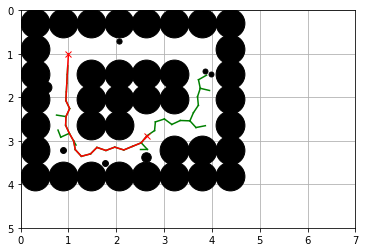

In [131]:
from notebooks.code.exercise_04_path_planning.RRT import RTT_Path_Follower

new_env = topViewSimulator()
new_env = launch_env(simclass = topViewSimulator, map_name ="loop_obstacles")
new_env = wrap_env(new_env)
new_env = SteeringToWheelVelWrapper(new_env)
new_env.reset()

goal = [1, 1]

dist_to_goal =  get_dist_to_goal(local_env.cur_pos, goal)
my_path = make_plan(new_env)

path_follower = RTT_Path_Follower(my_path, new_env)

while dist_to_goal > 0.3:
    if my_path is None:
        break
    v, omega = path_follower.next_action()
    obs, _, d, _ = new_env.step([v, omega])
    if d:
        print("Crash")
        break
    dist_to_goal =  get_dist_to_goal(new_env.cur_pos, goal)


Once you are done and the code above works (don't forget to run again the definition of `make_plan()` to enact your modifications), you can see what is happening here:

In [132]:
new_env.close()
view_results_ipython(new_env)


Whithin section 3 of **04-path-planning.txt**, answer the following question:

*While this algorithm works, it can definitely be improved in safety, computation efficiency and time to reach the objective. Describe one improvement that could be implemented for each of these aspects.*

Don't forget to add the file **RRT.py** to your submission!


## Bonus

If you want to implement one of these improvements, you can do so in the following by submitting an **RRT_bonus.py** file that includes the improved planner and path follower (you can start with a copy paste of the RRT.py file). 
Implement your demonstration here:

In [ ]:
from notebooks.code.exercise_04_path_planning.RRT_bonus import RRT_planner, RTT_Path_Follower

bonus_env = topViewSimulator()
bonus_env = launch_env(simclass = topViewSimulator, map_name ="loop_obstacles")
bonus_env = wrap_env(bonus_env)
bonus_env = SteeringToWheelVelWrapper(bonus_env)
bonus_env.reset()

goal = [1, 1]

####
#
#   Your demonstration here
#
####

See what is happening here:

In [ ]:
bonus_env.close()
view_results_ipython(bonus_env)

Don't forget to submit a detailed description of the improvement you made in section Bonus of **04-path-planning.txt**, and to include the code you used in the demonstration cell.
